ML Classification of Infant Cries

In [ ]:
#!git clone https://github.com/gveres/donateacry-corpus.git

EDA

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Total Samples: 680
                                            filepath       label
0  /content/drive/MyDrive/Database/discomfort/d6c...  discomfort
1  /content/drive/MyDrive/Database/discomfort/7b0...  discomfort
2  /content/drive/MyDrive/Database/discomfort/999...  discomfort
3  /content/drive/MyDrive/Database/discomfort/837...  discomfort
4  /content/drive/MyDrive/Database/discomfort/837...  discomfort


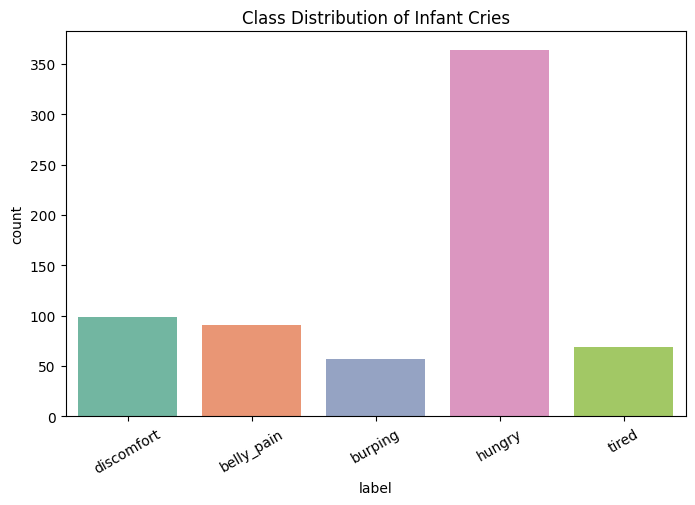

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Database"

filepaths = []
labels = []

for label in os.listdir(DATA_PATH):
    label_path = os.path.join(DATA_PATH, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.endswith(".wav"):
                filepaths.append(os.path.join(label_path, file))
                labels.append(label)

meta = pd.DataFrame({"filepath": filepaths, "label": labels})
print("Total Samples:", len(meta))
print(meta.head())

plt.figure(figsize=(8,5))
sns.countplot(x="label", hue="label", data=meta, palette="Set2")
plt.title("Class Distribution of Infant Cries")
plt.xticks(rotation=30)
plt.show()

In [ ]:
# ---Feature Extraction Function---

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Time-domain features
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
    rmse = np.mean(librosa.feature.rms(y=y))

    # Spectral features
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Spectral Contrast
    try:
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=4, fmin=50.0), axis=1)
    except:
        contrast = np.zeros(4)

    # Ensure all vectors have exact length 22
    features = [zcr, rmse, centroid, bandwidth, rolloff] + list(mfccs_mean[:13]) + list(contrast[:4])
    return features


# ---Extract Features for All Files---

features_list = []

for idx, row in meta.iterrows():
    try:
        feats = extract_features(row['filepath'])
        if len(feats) != 22:   # safety check
            print(f"[Warning] Skipped {row['filepath']} -> feature length {len(feats)}")
            feats = [0]*22
        features_list.append(feats)
    except Exception as e:
        print(f"[Warning] Skipped {row['filepath']} -> {e}")
        features_list.append([0]*22)

# Column names
col_names = ["zcr", "rmse", "centroid", "bandwidth", "rolloff"] + \
            [f"mfcc_{i}" for i in range(13)] + \
            [f"contrast_{i}" for i in range(4)]

# Create DataFrame
df_features = pd.DataFrame(features_list, columns=col_names)
df_features["label"] = meta["label"].values  # match lengths

print(df_features.head())

        zcr      rmse     centroid   bandwidth      rolloff      mfcc_0  \
0  0.427388  0.061779  1802.800158  837.009305  2743.939836 -208.640823   
1  0.118101  0.046066   793.213401  754.241000  1469.256366 -222.480972   
2  0.124268  0.033658   776.727895  575.329557  1328.161169 -337.972076   
3  0.135227  0.005000   980.669625  912.984589  2136.647076 -415.989136   
4  0.135227  0.005000   980.669625  912.984589  2136.647076 -415.989136   

       mfcc_1     mfcc_2     mfcc_3     mfcc_4  ...     mfcc_8     mfcc_9  \
0  -28.164577 -59.126392 -10.630727 -19.886158  ... -15.480292 -11.093403   
1  106.592682  -2.445994   7.357970 -19.878784  ... -12.498249   3.451674   
2  121.296394 -52.742359   9.147030 -16.707531  ...  -7.763032 -12.792732   
3   82.613083   7.484904   3.945976 -27.080709  ... -12.131386  -5.606012   
4   82.613083   7.484904   3.945976 -27.080709  ... -12.131386  -5.606012   

     mfcc_10   mfcc_11   mfcc_12  contrast_0  contrast_1  contrast_2  \
0  -3.498540  

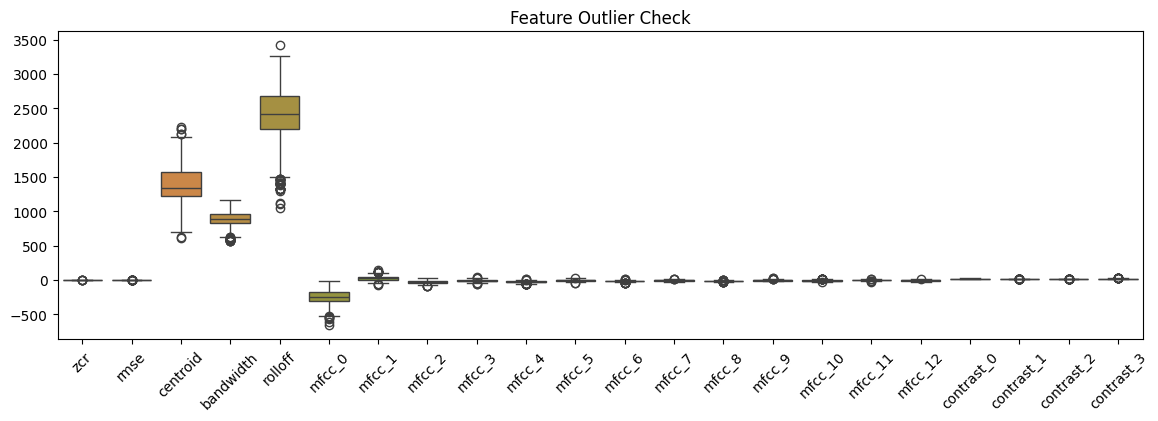

In [ ]:
# ---Data Quality & Distribution Checks---

# Boxplot for outliers
plt.figure(figsize=(14,4))
sns.boxplot(data=df_features.drop("label", axis=1))
plt.xticks(rotation=45)
plt.title("Feature Outlier Check")
plt.show()

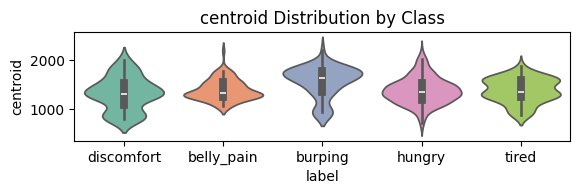

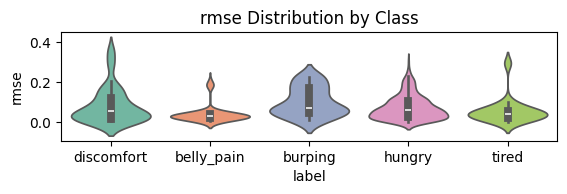

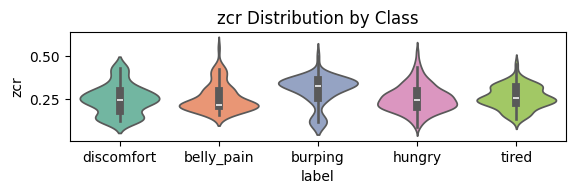

In [ ]:
#plt.figure(figsize=(16, 16))
i = 1
# Violin plots for key features
for feat in ["centroid", "rmse", "zcr"]:
    plt.subplot(3,1,i)
    sns.violinplot(x="label", y=feat, hue='label', data=df_features, palette="Set2",legend=False)
    plt.title(f"{feat} Distribution by Class")
    plt.show()
    i += 1

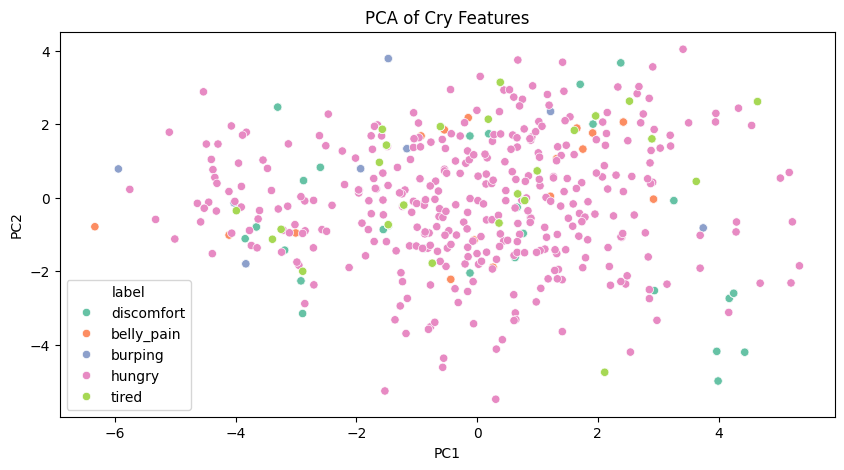

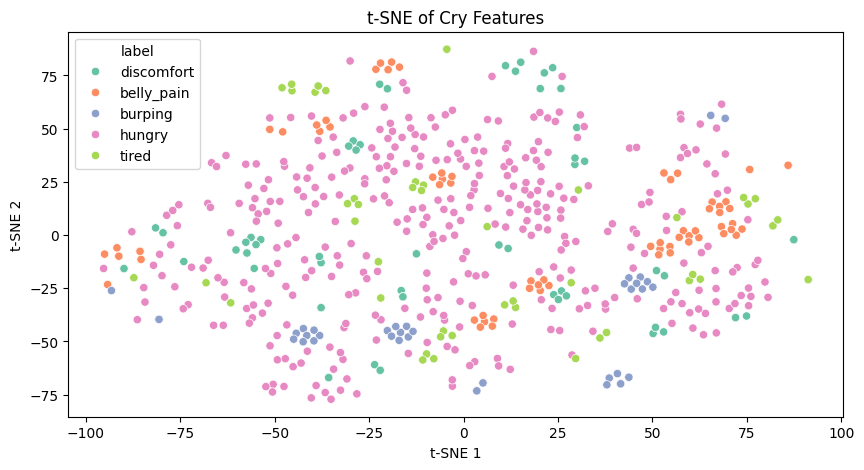

In [ ]:
# ---PCA Visualization---

X = df_features.drop("label", axis=1)
y = df_features["label"]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set2")
plt.title("PCA of Cry Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10,5))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette="Set2")
plt.title("t-SNE of Cry Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

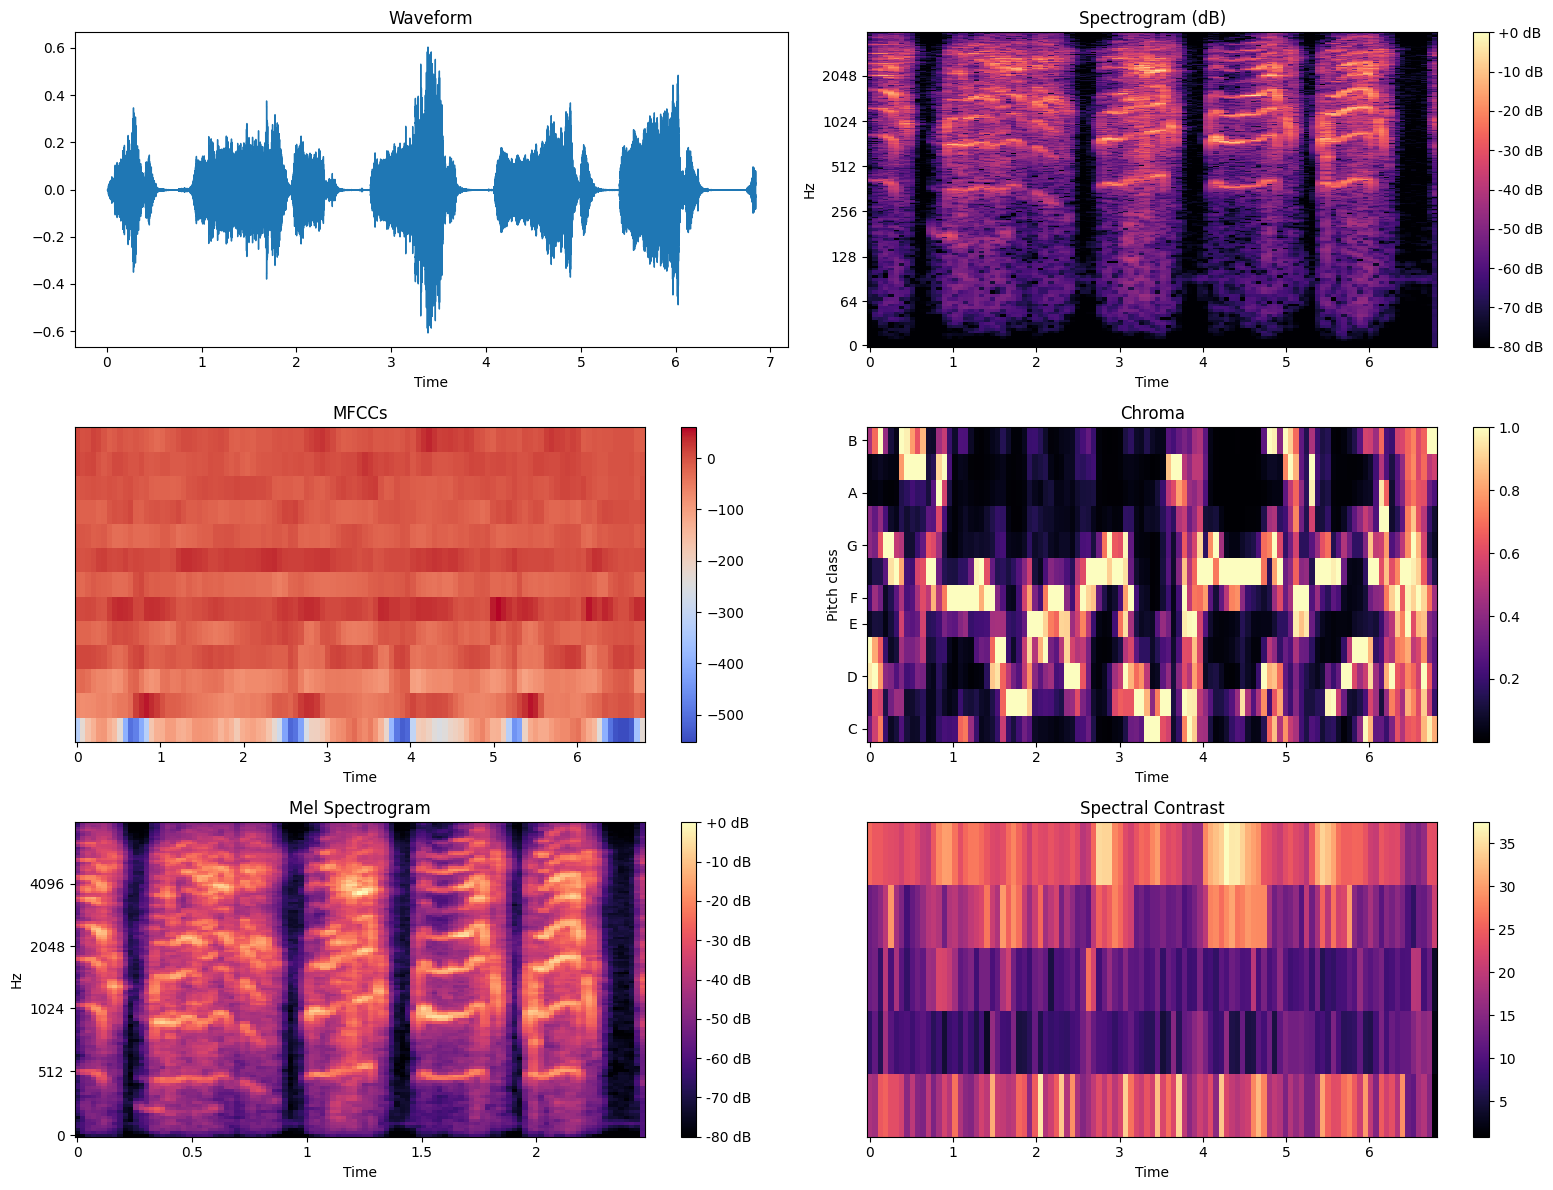

In [ ]:
# Audio Plots
file_path = meta.iloc[0]['filepath']
label = meta.iloc[0]['label']
y, sr = librosa.load(file_path, sr=None)

plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")

plt.subplot(3, 2, 2)
D = np.abs(librosa.stft(y))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

plt.subplot(3, 2, 3)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
librosa.display.specshow(mfccs, x_axis="time", sr=sr)
plt.colorbar()
plt.title("MFCCs")

plt.subplot(3, 2, 4)
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
librosa.display.specshow(chroma, y_axis="chroma", x_axis="time", sr=sr)
plt.colorbar()
plt.title("Chroma")

plt.subplot(3, 2, 5)
mel = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(librosa.power_to_db(mel, ref=np.max),
                         y_axis="mel", fmax=8000, x_axis="time")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")

plt.subplot(3, 2, 6)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=4, fmin=50.0)
librosa.display.specshow(contrast, x_axis="time", sr=sr)
plt.colorbar()
plt.title("Spectral Contrast")

plt.tight_layout()
plt.show()